# Postprocessing and Model Building

In [65]:
import os
import pickle
import json
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

In [66]:
with open('/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/software_inferences_sim_3.pkl', 'rb') as f:
    test = pickle.load(f)

In [67]:
test['opt_params_dadi']

[{'N0': 8401.29151881397,
  'Nb': 1437.0308988424308,
  'N_recover': 6223.381069431718,
  't_bottleneck_start': 1534.0387685837384,
  't_bottleneck_end': 115.07192640240497,
  'll': 253.65554852210425},
 {'N0': 8400.98326822118,
  'Nb': 1286.769158500069,
  'N_recover': 6222.672563434122,
  't_bottleneck_start': 1526.9167875590103,
  't_bottleneck_end': 100.25172042620905,
  'll': 253.65137163156578}]

In [68]:
test['simulated_params']

{'N0': 8332,
 'Nb': 4607,
 'N_recover': 6217,
 't_bottleneck_start': 1828,
 't_bottleneck_end': 953}

In [20]:
main_filepath = '/projects/kernlab/akapoor/Demographic_Inference'

CONFIG_FILEPATH = f'{main_filepath}/experiment_config.json'
MODEL_CONFIG_FILEPATH = f'{main_filepath}/model_config.json'

with open(CONFIG_FILEPATH, 'r') as f:
   experiment_config = json.load(f)

with open(MODEL_CONFIG_FILEPATH, 'r') as f:
   model_config = json.load(f)


CWD = os.getcwd()

# Use double quotes for the dictionary keys inside the f-string
EXPERIMENT_DIRECTORY = f"{experiment_config['demographic_model']}_dadi_analysis_{experiment_config['dadi_analysis']}_moments_analysis_{experiment_config['moments_analysis']}_momentsLD_analysis_{experiment_config['momentsLD_analysis']}_seed_{experiment_config['seed']}"
EXPERIMENT_NAME = f'sims_pretrain_{experiment_config["num_sims_pretrain"]}_sims_inference_{experiment_config["num_sims_inference"]}_seed_{experiment_config["seed"]}_num_replicates_{experiment_config["k"]}_top_values_{experiment_config["top_values_k"]}'
SIM_DIRECTORY = f"{EXPERIMENT_DIRECTORY}/sims/{EXPERIMENT_NAME}"

# Check if hidden_size is a list, and if so, join the elements with "_"
hidden_size = model_config['neural_net_hyperparameters']['hidden_size']
if isinstance(hidden_size, list):
    hidden_size_str = "_".join(map(str, hidden_size))  # Join list elements with "_"
else:
    hidden_size_str = str(hidden_size)  # Convert integer to string if not a list

# Build the MODEL_DIRECTORY string
MODEL_DIRECTORY = (
    f"{EXPERIMENT_DIRECTORY}/models/{EXPERIMENT_NAME}/"
    f"num_hidden_neurons_{hidden_size_str}_"
    f"num_hidden_layers_{model_config['neural_net_hyperparameters']['num_layers']}_"
    f"num_epochs_{model_config['neural_net_hyperparameters']['num_epochs']}_"
    f"dropout_value_{model_config['neural_net_hyperparameters']['dropout_rate']}_"
    f"weight_decay_{model_config['neural_net_hyperparameters']['weight_decay']}_"
    f"batch_size_{model_config['neural_net_hyperparameters']['batch_size']}_"
    f"EarlyStopping_{model_config['neural_net_hyperparameters']['EarlyStopping']}"
)


In [21]:
os.chdir('/projects/kernlab/akapoor/Demographic_Inference/')
os.environ['PYTHONPATH'] = '/projects/kernlab/akapoor/Demographic_Inference:' + os.environ.get('PYTHONPATH', '')

Just to check again, I want to look at the results for preprocessing

In [22]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'preprocessing_results_obj.pkl'), 'rb') as f:
    preproc = pickle.load(f)

In [23]:
preproc['training']['indices'][0]

1020

In [24]:
preproc['training']['predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,moments_rep1_FIM_element_6,moments_rep1_FIM_element_7,...,moments_rep2_N_recover,dadi_rep2_t_bottleneck_start,moments_rep2_t_bottleneck_start,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_start,momentsLD_t_bottleneck_end
0,8970.448642,9039.291024,0.053523,-0.099246,-0.058169,0.055483,0.017882,0.124078,-0.028773,-0.058124,...,7109.168552,1151.076795,1245.023913,384.427060,535.223825,8935.389196,3981.850033,6645.494396,1854.471426,1251.691682
1,9027.573032,9088.953446,0.050280,0.019399,-0.055345,-0.017446,0.017636,-0.036735,-0.030123,-0.056400,...,6200.031798,1290.823992,1212.062881,349.761444,149.257063,9476.187636,5063.707632,7709.715687,2121.259550,283.049183
2,9349.827296,9421.208354,0.053863,-0.079066,-0.058389,0.142609,0.017471,0.123229,-0.028903,-0.058361,...,6238.555226,1953.274064,2374.585195,86.597322,585.121669,9154.896278,5631.692726,6433.562277,2419.940304,1343.060222
3,8645.562517,8695.609594,0.053685,-0.066217,-0.058288,0.147217,0.017547,0.112284,-0.044335,-0.058301,...,6174.101581,3019.601436,2762.407015,2284.410336,1618.002409,8340.777645,255.894037,15810.203485,785.552455,736.127045
4,9350.262052,9409.626411,0.049881,0.001156,-0.054652,-0.092235,0.017764,-0.026513,-0.025461,-0.056353,...,6734.767121,1078.951422,977.475411,324.371110,94.077952,9282.068238,2823.319955,11329.374664,981.743280,485.292452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,8603.511506,8670.127939,0.053642,-0.079568,-0.058295,0.122332,0.017750,0.120974,-0.042844,-0.058304,...,6806.355561,1629.337717,1589.330156,151.676118,61.866229,8913.991752,3950.603504,12948.050959,1384.188741,326.523035
3957,9406.557967,9475.337314,0.051920,-0.019996,-0.057334,0.001482,0.017669,0.063000,-0.029208,-0.057348,...,6510.814313,1302.543909,1351.162968,263.387666,285.969903,9772.368970,4200.072773,8381.502843,1730.697099,354.149530
3958,8447.281554,8445.571559,0.054183,-0.131039,-0.058543,0.210965,0.017140,0.150536,-0.062314,-0.058441,...,6753.177327,1279.492547,1405.306219,565.406325,780.225757,8601.217075,4851.975407,5953.678809,1654.388559,686.820963
3959,10026.889684,9965.619314,0.053888,-0.075636,-0.058414,0.144592,0.017402,0.125421,-0.027040,-0.058389,...,6494.615524,2495.126236,2989.059735,227.468803,2111.870089,9289.929429,4043.507013,6461.141950,2857.491180,2796.125646


(array([1.696e+03, 7.630e+02, 1.201e+03, 2.290e+02, 6.500e+01, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  188.66118856,  2137.1204684 ,  4085.57974824,  6034.03902807,
         7982.49830791,  9930.95758775, 11879.41686758, 13827.87614742,
        15776.33542726, 17724.7947071 , 19673.25398693]),
 <BarContainer object of 10 artists>)

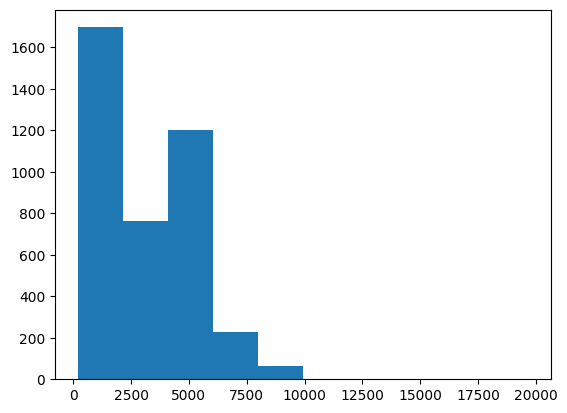

In [25]:
plt.figure()
plt.hist(preproc['training']['predictions']['dadi_rep1_Nb'])

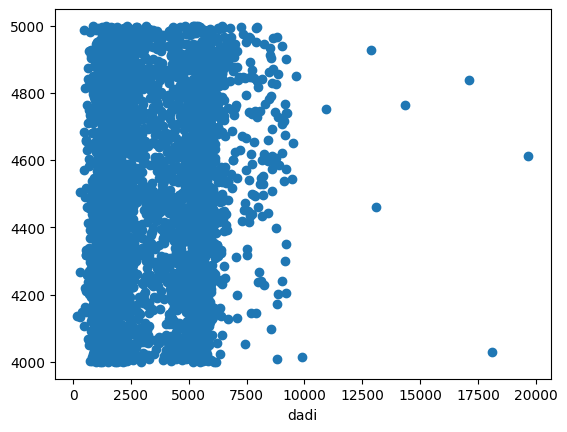

In [64]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(preproc['training']['predictions']['dadi_rep1_Nb'], preproc['training']['targets']['simulated_params_Nb'])
plt.xlabel("dadi")
plt.show()

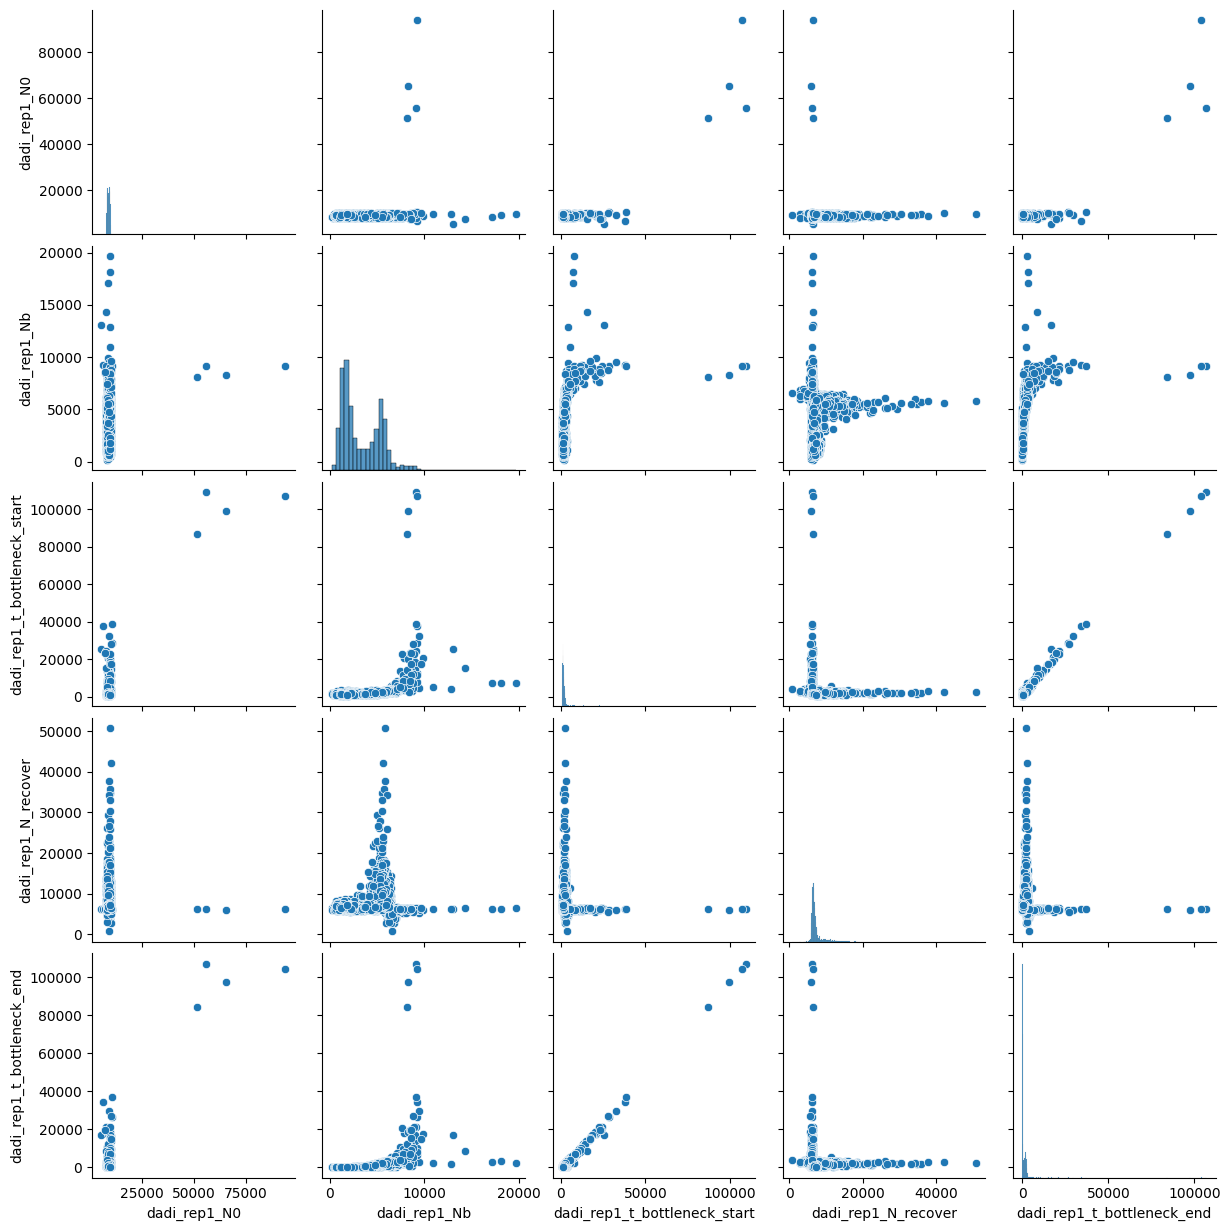

In [27]:
import seaborn as sns
import pandas as pd

# Select the columns for pairplot from the DataFrame
data = preproc['training']['predictions'][['dadi_rep1_N0', 'dadi_rep1_Nb', 'dadi_rep1_t_bottleneck_start', 'dadi_rep1_N_recover', 'dadi_rep1_t_bottleneck_end']]

# Ensure the input data is a DataFrame (sanity check)
if not isinstance(data, pd.DataFrame):
    raise ValueError("Input to sns.pairplot must be a DataFrame.")

# Create the pairplot
sns.pairplot(data)


In [28]:
import pandas as pd

# Count rows with at least one NaN
rows_with_nan = preproc['training']['predictions'].isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {rows_with_nan}")


Number of rows with at least one NaN: 0


In [29]:
import pandas as pd

# Assuming preproc['training']['predictions'] is a DataFrame
predictions_df = preproc['training']['predictions']

# Count rows with at least one NaN value
rows_with_nan = predictions_df.isna().any(axis=1).sum()

print(f"Number of rows with at least one NaN value: {rows_with_nan}")


Number of rows with at least one NaN value: 0


In [30]:
preproc['training']['predictions']['moments_rep1_N0']

0       9039.291024
1       9088.953446
2       9421.208354
3       8695.609594
4       9409.626411
           ...     
3956    8670.127939
3957    9475.337314
3958    8445.571559
3959    9965.619314
3960    9826.859381
Name: moments_rep1_N0, Length: 3961, dtype: float64

In [31]:
np.max(preproc['training']['targets']['simulated_params_N0'])

9999

In [32]:
np.min(preproc['training']['targets']['simulated_params_N0'])

8000

In [33]:
preproc['training']['targets']['simulated_params_N0']

0       9066
1       9155
2       9367
3       8615
4       9395
        ... 
3956    8692
3957    9413
3958    8522
3959    9939
3960    9872
Name: simulated_params_N0, Length: 3961, dtype: int64

In [34]:
preproc['training']['predictions']['dadi_rep1_N0']

0        8970.448642
1        9027.573032
2        9349.827296
3        8645.562517
4        9350.262052
            ...     
3956     8603.511506
3957     9406.557967
3958     8447.281554
3959    10026.889684
3960     9747.157253
Name: dadi_rep1_N0, Length: 3961, dtype: float64

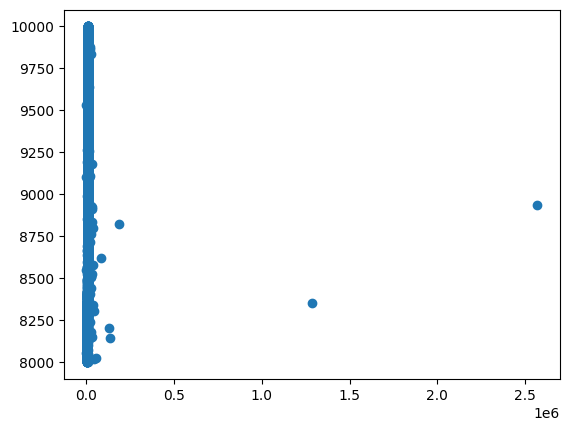

In [35]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['moments_rep1_N0'], preproc['training']['targets']['simulated_params_N0'])
# Set the zoomed-in range for the axes
# # Show the zoomed-in plot
# plt.show()
plt.show()

In [36]:
with open('/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/software_inferences_sim_810.pkl', 'rb') as f:
    a = pickle.load(f)

In [37]:
a['simulated_params']

{'N0': 8636,
 'Nb': 4680,
 'N_recover': 6822,
 't_bottleneck_start': 1935,
 't_bottleneck_end': 869}

In [38]:
a['opt_params_dadi']

[{'N0': 8582.196061915745,
  'Nb': 5939.338833567194,
  'N_recover': 8611.300802609909,
  't_bottleneck_start': 2760.9490443799727,
  't_bottleneck_end': 2660.7478485867177,
  'll': -234.12409080016187},
 {'N0': 8584.315605011348,
  'Nb': 5940.873922714455,
  'N_recover': 8522.531392671215,
  't_bottleneck_start': 2769.6681167824727,
  't_bottleneck_end': 2667.2350138281904,
  'll': -234.1326764155301}]

## Postprocessing

In [39]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/postprocessing.py \
    --config_file $CONFIG_FILEPATH \
    --training_features_filepath $SIM_DIRECTORY/training_features.csv \
    --training_targets_filepath $SIM_DIRECTORY/training_targets.csv \
    --validation_features_filepath $SIM_DIRECTORY/validation_features.csv \
    --validation_targets_filepath $SIM_DIRECTORY/validation_targets.csv \
    --sim_directory $SIM_DIRECTORY



Processing training data:
===> Normalizing the data.

Processing validation data:
===> Normalizing the data.
Postprocessing dict keys: dict_keys(['normalization', 'predictions', 'normalized_predictions', 'targets', 'normalized_targets'])
Postprocessing complete!


In [40]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'postprocessing_results.pkl'), 'rb') as f:
    post = pickle.load(f)

In [41]:
post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end']

0       -10.938971
1       -12.985730
2       -13.787730
3        25.288855
4       -11.912380
           ...    
3956    -13.465630
3957    -12.180366
3958     -4.358142
3959    242.993489
3960    -12.025520
Name: dadi_rep1_t_bottleneck_end, Length: 3961, dtype: float64

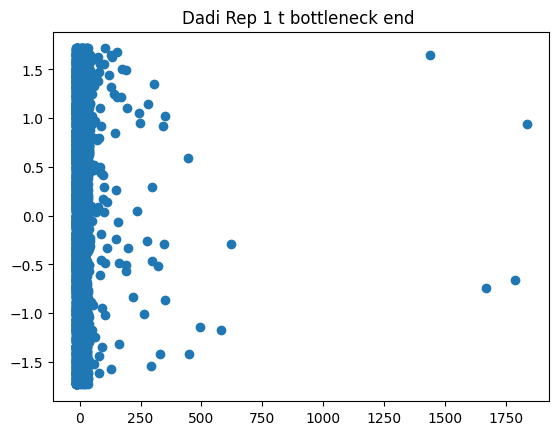

In [42]:
plt.figure()
plt.title("Dadi Rep 1 t bottleneck end ")
plt.scatter(post['training']['normalized_predictions']['dadi_rep1_t_bottleneck_end'], post['training']['normalized_targets']['simulated_params_t_bottleneck_end'])
plt.show()

## Calculate the MSE for each analysis type and for each stage.

In [43]:
post['training']['normalized_predictions']

,dadi_rep1_N0,moments_rep1_N0,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,moments_rep1_FIM_element_6,moments_rep1_FIM_element_7,...,moments_rep2_N_recover,dadi_rep2_t_bottleneck_start,moments_rep2_t_bottleneck_start,dadi_rep2_t_bottleneck_end,moments_rep2_t_bottleneck_end,momentsLD_N0,momentsLD_Nb,momentsLD_N_recover,momentsLD_t_bottleneck_start,momentsLD_t_bottleneck_end
0,-0.051184,0.068054,0.053523,-0.099246,-0.058169,0.055483,0.017882,0.124078,-0.028773,-0.058124,...,2.110222,-4.149462,-3.498577,-8.929985,-6.318109,-0.111909,-1.794924,0.504007,0.723799,6.091479
1,0.047758,0.154072,0.050280,0.019399,-0.055345,-0.017446,0.017636,-0.036735,-0.030123,-0.056400,...,-1.039120,-3.181265,-3.726938,-9.530411,-13.003249,0.824781,1.952741,4.190578,2.572162,-10.685902
2,0.605919,0.729554,0.053863,-0.079066,-0.058389,0.142609,0.017471,0.123229,-0.028903,-0.058361,...,-0.905671,1.408324,4.327253,-14.088548,-5.453853,0.268288,3.920299,-0.230147,4.641483,7.674028
3,-0.613904,-0.527220,0.053685,-0.066217,-0.058288,0.147217,0.017547,0.112284,-0.044335,-0.058301,...,-1.128945,8.796057,7.014162,23.978690,12.436167,-1.141807,-14.702014,32.251491,-6.681889,-2.838363
4,0.606672,0.709494,0.049881,0.001156,-0.054652,-0.092235,0.017764,-0.026513,-0.025461,-0.056353,...,0.813257,-4.649161,-5.352207,-9.970185,-13.958979,0.488557,-5.808190,16.729445,-5.322639,-7.182945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,-0.686738,-0.571355,0.053642,-0.079568,-0.058295,0.122332,0.017750,0.120974,-0.042844,-0.058304,...,1.061247,-0.835973,-1.113153,-12.961350,-14.516903,-0.148971,-1.903165,22.336704,-2.534415,-9.932912
3957,0.704179,0.823308,0.051920,-0.019996,-0.057334,0.001482,0.017669,0.063000,-0.029208,-0.057348,...,0.037462,-3.100067,-2.763224,-11.026449,-10.635313,1.337782,-1.038978,6.517717,-0.133734,-9.454407
3958,-0.957336,-0.960298,0.054183,-0.131039,-0.058543,0.210965,0.017140,0.150536,-0.062314,-0.058441,...,0.877032,-3.259771,-2.388109,-5.795332,-2.074551,-0.690712,1.219279,-1.892512,-0.662415,-3.692369
3959,1.778625,1.672502,0.053888,-0.075636,-0.058414,0.144592,0.017402,0.125421,-0.027040,-0.058389,...,-0.018652,5.162386,8.584458,-11.648582,20.990206,0.502173,-1.581338,-0.134608,7.672924,32.841860


In [44]:
post['training']['normalized_predictions']['dadi_rep1_N0']

0      -0.051184
1       0.047758
2       0.605919
3      -0.613904
4       0.606672
          ...   
3956   -0.686738
3957    0.704179
3958   -0.957336
3959    1.778625
3960    1.294114
Name: dadi_rep1_N0, Length: 3961, dtype: float64

In [45]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_N0'], post['training']['normalized_targets']['simulated_params_N0'])

10.94293749993588

In [46]:
np.min(post['training']['normalized_predictions']['dadi_rep1_N0'])

-6.179433219610198

In [47]:
mean_squared_error(post['training']['normalized_predictions']['dadi_rep1_Nb'], post['training']['normalized_targets']['simulated_params_Nb'])

66.83689704782192

In [48]:
np.max(post['training']['normalized_predictions']['dadi_rep1_Nb'])

52.561693643032974

In [49]:
post['training']['normalized_targets']['simulated_params_Nb']

0       0.301377
1      -1.080800
2       0.128172
3      -1.697410
4       1.389105
          ...   
3956    0.239023
3957   -1.271325
3958    1.205507
3959    1.215900
3960    1.628128
Name: simulated_params_Nb, Length: 3961, dtype: float64

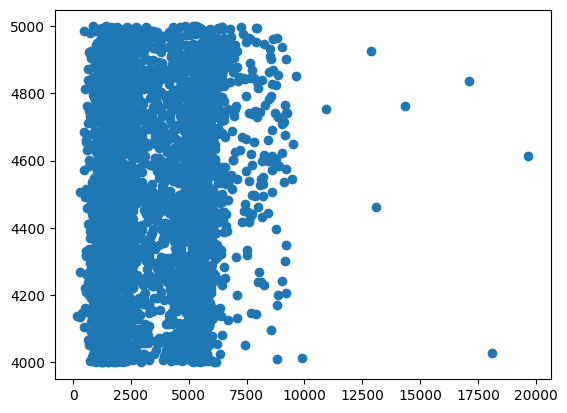

In [50]:
import matplotlib.pyplot as plt
plt.scatter(preproc['training']['predictions']['dadi_rep1_Nb'], preproc['training']['targets']['simulated_params_Nb'])

In [51]:
def plot_mse_and_sem(mse_results, sem_results, title, parameters):
    """
    Create a grouped bar plot showing MSE values with error bars for each parameter and analysis type.
    
    Parameters:
    -----------
    mse_results : dict
        Dictionary containing MSE values for each analysis type and parameter
    sem_results : dict
        Dictionary containing SEM values for each analysis type and parameter
    title : str
        Title for the plot
    parameters : list
        List of parameter names to plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure and axis with clean style
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Number of parameter groups and analysis types
    n_parameters = len(parameters)
    n_analyses = len(mse_results.keys())
    
    # Width of each bar and positions of the bars
    bar_width = 0.25
    index = np.arange(n_parameters)
    
    # Colors for different analysis types - using more distinct colors
    colors = ['#2ecc71', '#3498db', '#e74c3c']  # green, blue, red
    
    # Plot bars for each analysis type
    for i, (analysis_type, color) in enumerate(zip(mse_results.keys(), colors)):
        mse_values = []
        sem_values = []
        for param in parameters:
            mse_values.append(mse_results[analysis_type].get(param, 0))
            sem_values.append(sem_results[analysis_type].get(param, 0))
        
        positions = index + (i - 1) * bar_width
        bars = ax.bar(positions, mse_values, bar_width,
                     label=analysis_type, color=color, alpha=0.8)
        
        # Add error bars
        ax.errorbar(positions, mse_values, yerr=sem_values,
                   fmt='none', color='black', capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=10)
    ax.set_title(title, fontsize=12, pad=20)
    ax.set_xticks(index)
    ax.set_xticklabels(parameters, fontsize=10)
    
    # Add legend with better positioning
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Add grid with light color
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

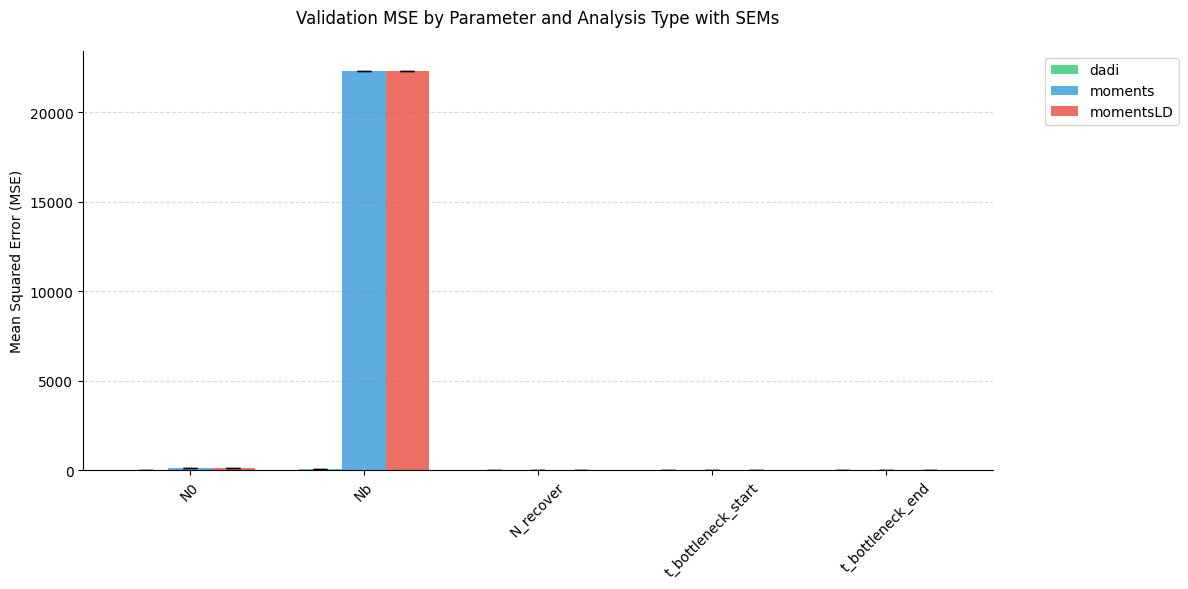

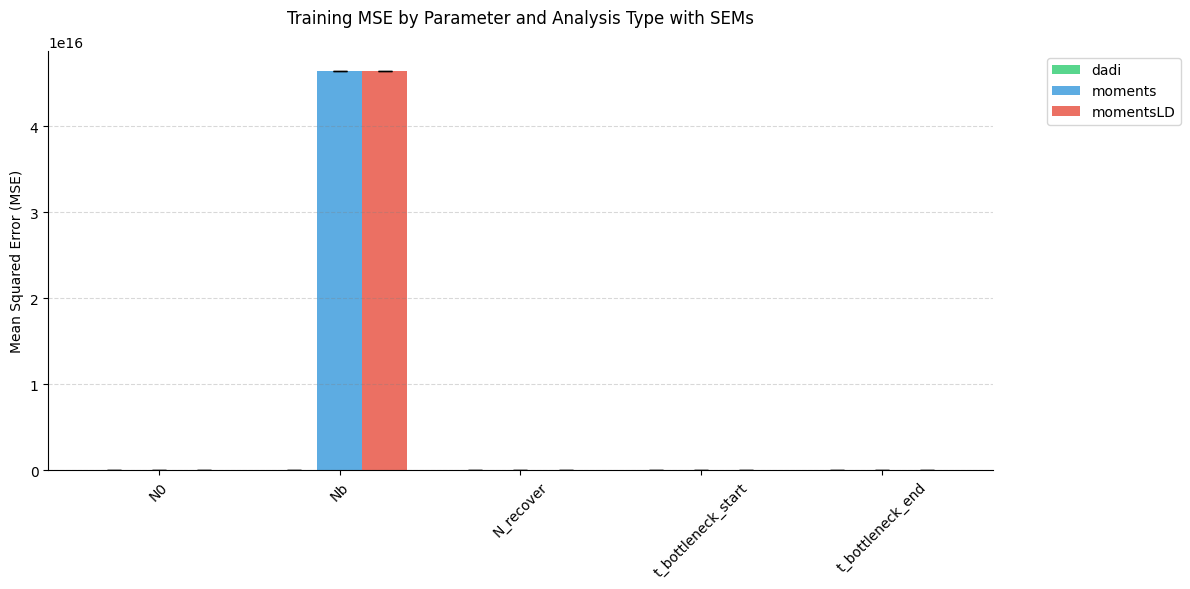

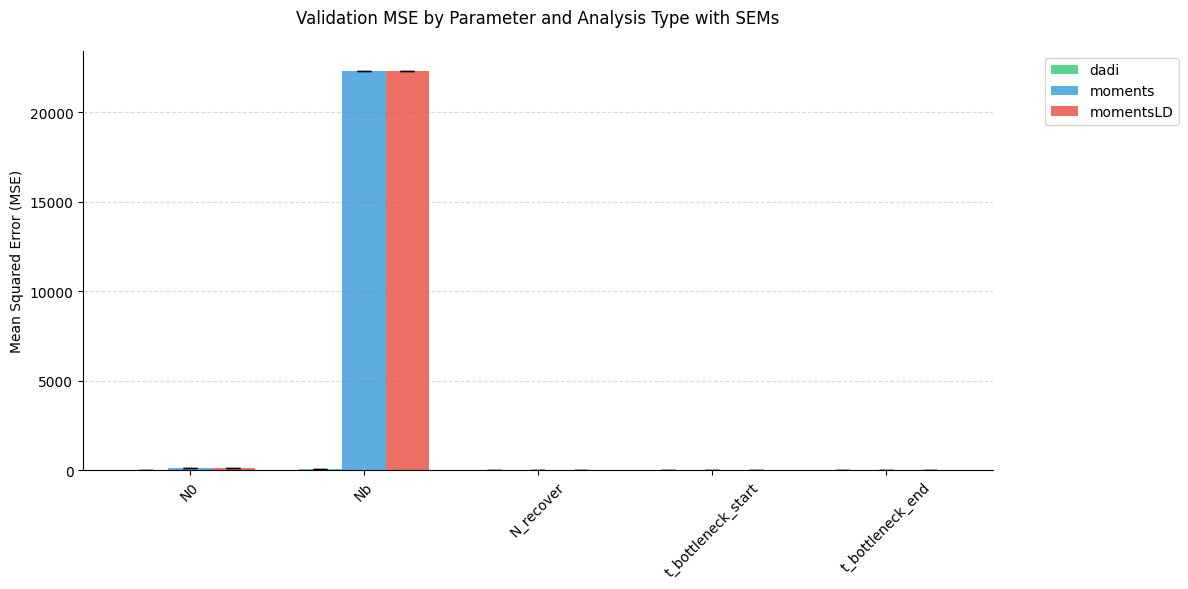

In [52]:
# Updated function to handle underscores in parameter names correctly
def calculate_mse_and_sem(post, key):
    predictions = post[key]['normalized_predictions']
    targets = post[key]['normalized_targets']
    mse_results = {}
    sem_results = {}

    for analysis_type in ['dadi', 'moments', 'momentsLD']:
        mse_values = {}
        sem_values = {}
        for column in predictions.columns:
            if column.startswith(analysis_type):
                # Extract parameter name after the last '_'
                param_name = "_".join(column.split('_')[-2:]) if 't_split' in column else column.split('_')[-1]
                target_column = f"simulated_params_{param_name}"
                if target_column in targets.columns:
                    mse = mean_squared_error(targets[target_column], predictions[column])
                    mse_values[param_name] = mse
                    sem = np.std(targets[target_column] - predictions[column]) / np.sqrt(len(targets[target_column]))
                    sem_values[param_name] = sem
        if mse_values:
            mse_results[analysis_type] = mse_values
            sem_results[analysis_type] = sem_values
    return mse_results, sem_results

# Parameters list
# parameters = ['Na', 'N1', 'N2', "t_split"]
parameters = experiment_config['parameters_to_estimate']

# Recalculate MSE and SEM for training and validation with the updated function
training_mse, training_sem = calculate_mse_and_sem(post, 'training')
validation_mse, validation_sem = calculate_mse_and_sem(post, 'validation')

# Re-plot with the fixed parameter handling
plot_mse_and_sem(training_mse, training_sem, "Training MSE by Parameter and Analysis Type with SEMs", parameters)
plot_mse_and_sem(validation_mse, validation_sem, "Validation MSE by Parameter and Analysis Type with SEMs", parameters)

In [56]:
training_mse

{'dadi': {'N0': 18.13712907015073, 'Nb': 54.88070218162515},
 'moments': {'N0': 77.14639161376816, 'Nb': 4.642727057060886e+16},
 'momentsLD': {'N0': 77.14639161376816, 'Nb': 4.642727057060886e+16}}

In [57]:
validation_mse

{'dadi': {'N0': 0.030694578706619298, 'Nb': 50.32158487501702},
 'moments': {'N0': 123.29954614915064, 'Nb': 22311.672631806432},
 'momentsLD': {'N0': 123.29954614915064, 'Nb': 22311.672631806432}}

In [58]:
post['training']['predictions'].columns

Index(['dadi_rep1_N0', 'moments_rep1_N0', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'moments_rep1_FIM_element_6',
       'moments_rep1_FIM_element_7', 'moments_rep1_FIM_element_8',
       'moments_rep1_FIM_element_9', 'dadi_rep1_Nb', 'moments_rep1_Nb',
       'dadi_rep1_N_recover', 'moments_rep1_N_recover',
       'dadi_rep1_t_bottleneck_start', 'moments_rep1_t_bottleneck_start',
       'dadi_rep1_t_bottleneck_end', 'moments_rep1_t_bottleneck_end',
       'dadi_rep2_N0', 'moments_rep2_N0', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'moments_rep2_FIM_element_6',
       'moments_rep2_FIM_element_7', 'moments_rep2_FIM_element_8',
       'moments_rep2_FIM_element_9', 'dadi_rep2_

## Extracting Features

In [59]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/extracting_features.py \
 --postprocessing_results_filepath $SIM_DIRECTORY/postprocessing_results.pkl \
 --sim_directory $SIM_DIRECTORY

dict_keys(['parameter_names', 'target_names', 'training', 'validation'])
Training features shape: (3961, 45)
Validation features shape: (991, 45)
Training targets shape: (3961, 5)
Validation targets shape: (991, 5)


## Linear Evaluation

In [60]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type standard

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
Initializing LinearRegression with kwargs={}
PREDICTIONS SHAPE TRAINING: (3961, 5)
[1.00474174 1.20865012 0.37243808 ... 0.91134905 0.56086658 0.7787216 ]
[1.17917316e+00 1.17966634e+00 4.84931129e-01 2.60983091e-01
 1.13466470e+00 1.21310822e+00 3.20778290e-01 1.21023791e+00
 1.26278842e+00 6.44289317e-01 8.39272770e-01 9.79179351e-01
 3.19230284e-01 5.19194369e-01 7.00475360e-01 1.05994435e+00
 6.30815946e-01 4.10119032e-01 1.11888610e+00 8.52377514e-01
 4.61717027e-01 7.82800618e-01 5.27030081e-01 5.97142717e-01
 4.86779837e-01 4.58337668e-01 1.22520026e+00 2.59403645e-01
 7.25325287e-01 1.07589966e+00 5.22031625e-01 1.27883140e+00
 9.34580443e-01 1.02892998e+00

### Ridge

In [ ]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type ridge

### Lasso

In [63]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type lasso

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.643e+02, tolerance: 3.220e-01
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

### Elastic Net

In [ ]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type elasticnet

## Random Forest

In [61]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/random_forest_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'random_state': 123, 'n_estimators': 300, 'min_samples_split': 10, 'max_depth': None}

Initializing RandomForestRegressor with kwargs={'n_estimators': 300, 'max_depth': None, 'random_state': 123, 'min_samples_split': 10}

Random Forest predictions shape (training): (3961, 5)
Random Forest predictions shape (validation): (991, 5)

[0.1922298  0.04760301 0.06742672 ... 0.28660185 0.08502804 0.19829018]
[0.36063588 1.06610998 0.19799636 0.05051407 1.42150534 0.150912

## XGBoost

In [62]:
 !python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/xgboost_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: bottleneck_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/models/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No XGBoost hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Initializing XGBRegressor with kwargs={'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0}

XGBoost predictions shape (training): (3961, 5)
XGBoost predictions shape (validation): (991, 5)

[0.

## Neural Network

In [ ]:
    # parser.add_argument("--experiment_directory", type=str, required=True)
    # parser.add_argument("--model_config_file", type=str, required=True)
    # parser.add_argument("--features_file", type=str, required=True)
    # parser.add_argument("--color_shades", type=str, required=True)
    # parser.add_argument("--main_colors", type=str, required=True)

In [ ]:
preproc['training']['predictions']

In [ ]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/setup_trainer.py \
    --experiment_directory $EXPERIMENT_DIRECTORY \
    --model_config_file $MODEL_CONFIG_FILEPATH \
    --features_file $SIM_DIRECTORY/features_and_targets.pkl \
    --color_shades $SIM_DIRECTORY/color_shades.pkl \
    --main_colors $SIM_DIRECTORY/main_colors.pkl

In [ ]:
preproc['training']['predictions'].columns

In [ ]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")